In [59]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle

In [60]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## Definir a frequência para a amostragem

In [61]:
# definir frequência a ser considerada no modelo
frequencia = '2W' # 7D 15D 2W 3W M

In [62]:
# calcular períodos que cabem em um ano
intervalo_ano = pd.date_range(start='2018-01-01', end='2019-01-01', freq=frequencia)
periodos_ano = len(intervalo_ano) - 2
print('Frequência:', frequencia)
print('Períodos em um ano:', periodos_ano)

Frequência: 2W
Períodos em um ano: 24


## Carregar dados de entrada

In [63]:
prefixo_arquivos = ''
#prefixo_arquivos = 'https://github.com/hjort/ai-labs/raw/master/kaggle/serpro-weather/'

In [64]:
# carregar arquivo de dados de treino
train_data = pd.read_csv(prefixo_arquivos + 'weather-train.csv', index_col='date', parse_dates=['date'])
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-10-01 to 2016-11-16
Data columns (total 1 columns):
temperature    1507 non-null float64
dtypes: float64(1)
memory usage: 23.6 KB


,temperature
date,
2012-10-01,11.036840
2012-10-02,14.340558
2012-10-03,14.518382
2012-10-04,16.820351
2012-10-05,16.948431


In [65]:
# carregar arquivo de dados de teste
test_data = pd.read_csv(prefixo_arquivos + 'weather-test.csv', index_col='date', parse_dates=['date'])
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Empty DataFrame

""
date
2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21


## Realizar transformações nos dados

In [66]:
# remover valores nulos
data = train_data.dropna()

# reduzir a quantidade de dados para a frequência
data = data.resample(frequencia).mean()

# filtrar período desejado
data = data['2013-01':]
#data = data['2013-01':'2015-12']

# converter temperatura para Kelvin
#data['temperature'] += 273.15

data.head()

,temperature
date,
2013-01-13,-0.898616
2013-01-27,-4.363976
2013-02-10,-3.876506
2013-02-24,-1.576198
2013-03-10,-0.848570


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2013-01-13 to 2016-11-27
Freq: 2W-SUN
Data columns (total 1 columns):
temperature    102 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB


In [68]:
data.describe()

,temperature
count,102.000000
mean,13.105400
std,10.950965
min,-10.521017
25%,4.555104
50%,14.484964
75%,22.269942
max,31.861293


## Criar e analisar a série temporal

In [69]:
# criar série temporal a partir do dataframe
ts = data['temperature']
ts = ts.asfreq(frequencia)
ts.head()

date
2013-01-13   -0.898616
2013-01-27   -4.363976
2013-02-10   -3.876506
2013-02-24   -1.576198
2013-03-10   -0.848570
Freq: 2W-SUN, Name: temperature, dtype: float64

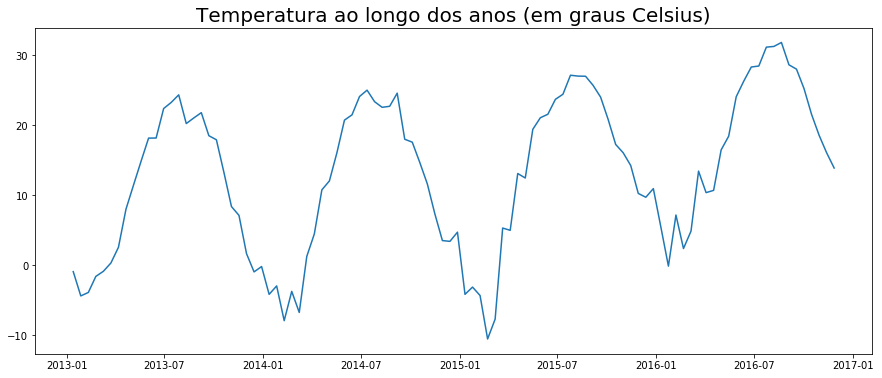

In [70]:
# plotar a série temporal
plt.plot(ts)
plt.title('Temperatura ao longo dos anos (em graus Celsius)', fontsize=20)
plt.show()

## Analisar estacionariedade

In [71]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=20)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=[
        'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

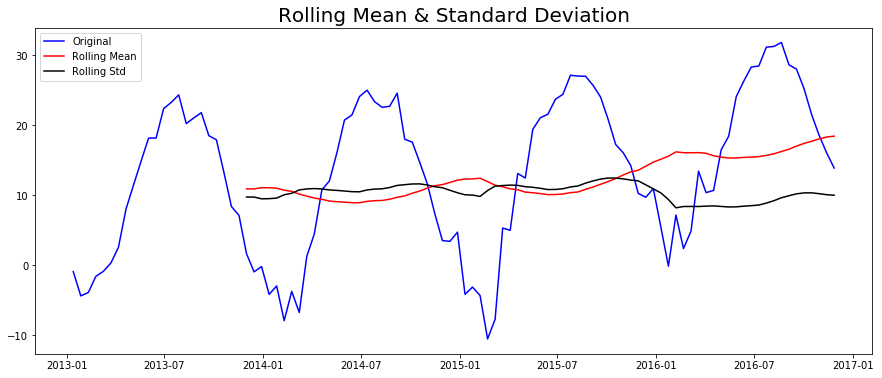

Results of Dickey-Fuller Test:
Test Statistic                 -5.584454
p-value                         0.000001
#Lags Used                      4.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


In [72]:
# avaliar se a série é estacionária
test_stationarity(ts, periodos_ano)

### Realizar testes para estimar parâmetros ARIMA

https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html

In [73]:
from pmdarima.arima.utils import ndiffs

dft = pd.DataFrame({
    'Teste': [
        'ADF (Augmented Dickey-Fuller)',
        'KPSS (Kwiatkowski–Phillips–Schmidt–Shin)',
        'PP (Phillips–Perron)'
    ],
    'Valor estimado para o termo "d"': [
        ndiffs(ts, test='adf'),
        ndiffs(ts, test='kpss'),
        ndiffs(ts, test='pp')
    ]
})
dft.set_index('Teste', inplace=True)
dft

,"Valor estimado para o termo ""d"""
Teste,
ADF (Augmented Dickey-Fuller),0
KPSS (Kwiatkowski–Phillips–Schmidt–Shin),0
PP (Phillips–Perron),1


https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.nsdiffs.html

In [74]:
from pmdarima.arima.utils import nsdiffs

dft = pd.DataFrame({
    'Teste': [
        'OCSB (Osborn-Chui-Smith-Birchenhall)',
        'CH (Canova-Hansen)'
    ],
    'Valor estimado para o termo "D"': [
        nsdiffs(ts, periodos_ano, test='ocsb'),
        nsdiffs(ts, periodos_ano, test='ch')
    ]
})
dft.set_index('Teste', inplace=True)
dft

,"Valor estimado para o termo ""D"""
Teste,
OCSB (Osborn-Chui-Smith-Birchenhall),0
CH (Canova-Hansen),0


## Analisar componente de sazonalidade

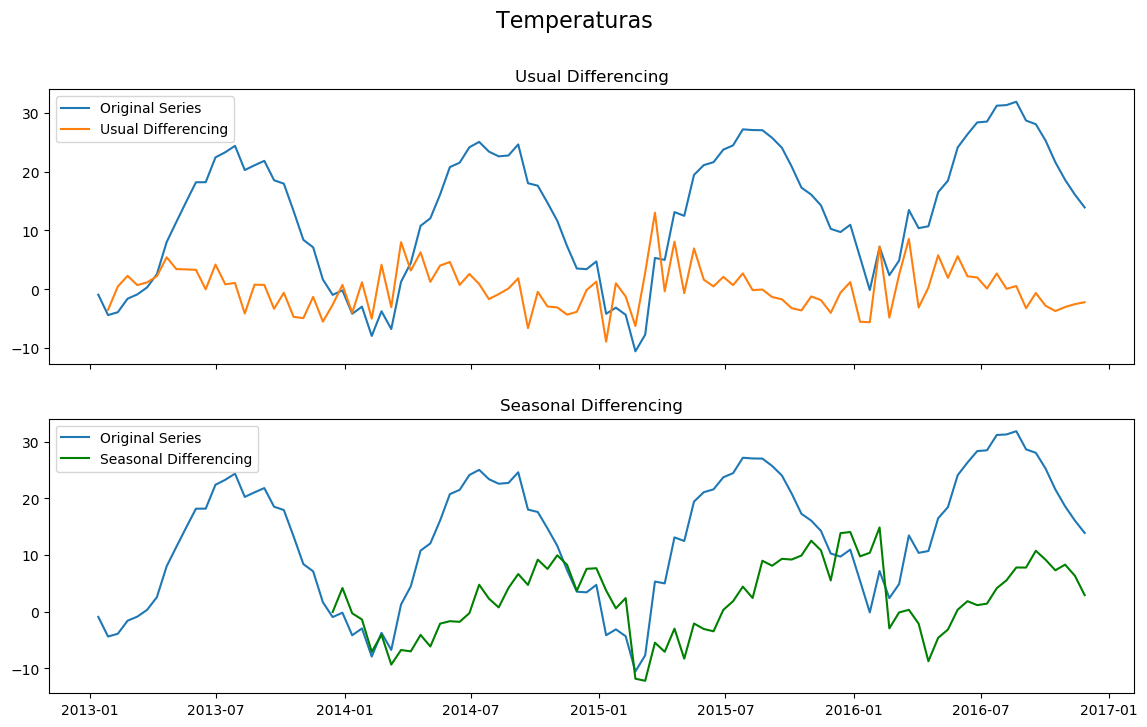

In [75]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(14,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(ts, label='Original Series')
axes[0].plot(ts.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal 1st
axes[1].plot(ts, label='Original Series')
axes[1].plot(ts.diff(periodos_ano), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Temperaturas', fontsize=16)
plt.show()

## Ajustar preditor ARIMA de forma automática
- https://www.alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [76]:
from pmdarima import auto_arima

# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=periodos_ano,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=514.914, BIC=519.628, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=439.050, BIC=448.477, Fit time=0.531 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=439.803, BIC=446.874, Fit time=0.066 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 24); AIC=440.113, BIC=451.897, Fit time=1.261 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 24); AIC=439.046, BIC=450.829, Fit time=2.082 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 2, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 24); AIC=504.918, BIC=514.345, Fit time=1.735 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 1, 24); AIC=438.887, BIC=45

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 24)   Log Likelihood                -206.502
Date:                            Fri, 30 Aug 2019   AIC                            429.004
Time:                                    09:58:15   BIC                            447.857
Sample:                                         0   HQIC                           436.551
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1453      0.105      1.385      0.166      -0.060       0.351
ar.L1          1.5183      0.137     11.092      0.000       1.250       1.787
ar.L2         -0.2123      0.243     -0.873      0.383      -0.689       0.264
ar.L3         -0.3766      0.120     -3.130      0.002      -0.612      -0.141
ma.L1         -0.8995      0.113     -7.974      0.000      -1.121      -0.678
ar.S.L24       0.2097      0.546      0.384      0.701      -0.860       1.279
ma.S.L24      -0.9998   1704.490     -0.001      1.000   -3341.738    3339.739
sigma2         7.9349   1.35e+04      0.001      1.000   -2.65e+04    2.65e+04
===================================================================================
Ljung-Box (Q):                       48.45   Jarque-Bera (JB):                10.69
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.54
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Avaliar o resultado das previsões futuras

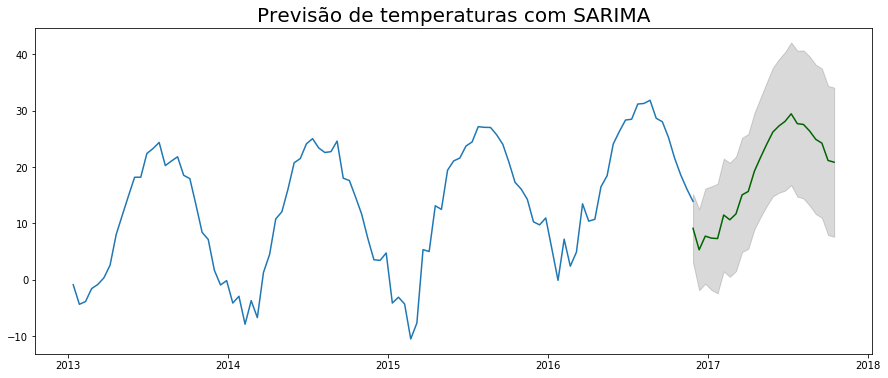

In [77]:
# Forecast
fitted, confint = smodel.predict(n_periods=periodos_ano, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods=periodos_ano, freq=frequencia)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ts)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Previsão de temperaturas com SARIMA", fontsize=20)
plt.show()

## Previsão de valores futuros com dados de teste

In [78]:
# obter intervalo de datas para a previsão
primeira_data = ts.index[-1] + 1
ultima_data = pd.Timestamp(test_data.index[-1], freq='M') + 2
print('Intervalo de datas: %s => %s' % (primeira_data, ultima_data))
datas_previsao = pd.date_range(start=primeira_data, end=ultima_data, freq=frequencia)
datas_previsao

Intervalo de datas: 2016-12-11 00:00:00 => 2017-12-31 00:00:00


DatetimeIndex(['2016-12-11', '2016-12-25', '2017-01-08', '2017-01-22',
               '2017-02-05', '2017-02-19', '2017-03-05', '2017-03-19',
               '2017-04-02', '2017-04-16', '2017-04-30', '2017-05-14',
               '2017-05-28', '2017-06-11', '2017-06-25', '2017-07-09',
               '2017-07-23', '2017-08-06', '2017-08-20', '2017-09-03',
               '2017-09-17', '2017-10-01', '2017-10-15', '2017-10-29',
               '2017-11-12', '2017-11-26', '2017-12-10', '2017-12-24'],
              dtype='datetime64[ns]', freq='2W-SUN')

In [79]:
# gerar novos valores a partir do modelo
periodos_previsao = len(datas_previsao)
valores_previstos = smodel.predict(n_periods=periodos_previsao)

In [80]:
# construir dataframe com previsão
df = pd.DataFrame({
    'date': datas_previsao,
    'temperature': valores_previstos
})
df.set_index('date', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2016-12-11 to 2017-12-24
Data columns (total 1 columns):
temperature    28 non-null float64
dtypes: float64(1)
memory usage: 448.0 bytes


,temperature
date,
2016-12-11,9.128021
2016-12-25,5.315978
2017-01-08,7.740271
2017-01-22,7.379889
2017-02-05,7.308713


In [81]:
# inserir na primeira posição os últimos valores de treino
df = (data.iloc[-2:]).append(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-11-13 to 2017-12-24
Data columns (total 1 columns):
temperature    30 non-null float64
dtypes: float64(1)
memory usage: 480.0 bytes


In [82]:
# obter intervalo de datas necessário
data_inicio = test_data.index[0]
data_final = test_data.index[-1]
print('Intervalo necessário:', data_inicio, '=>', data_final)

Intervalo necessário: 2016-11-17 00:00:00 => 2017-11-29 00:00:00


In [83]:
# interpolar dados para obter valores diários
pred_data = df.resample('D').interpolate(method='cubic')

# restringir ao intervalo de datas esperado
pred_data = pred_data[data_inicio:data_final]

# converter temperaturas novamente para graus Celsius
#pred_data['temperature'] -= 273.15

# exibir informações do dataframe
pred_data.info()
pred_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 378 entries, 2016-11-17 to 2017-11-29
Freq: D
Data columns (total 1 columns):
temperature    378 non-null float64
dtypes: float64(1)
memory usage: 5.9 KB


,temperature
date,
2016-11-17,15.848843
2016-11-18,15.734780
2016-11-19,15.601219
2016-11-20,15.448849
2016-11-21,15.278363


## Geração do arquivo de resultados

In [84]:
# gravar arquivo CSV com os resultados
nome_arquivo = 'weather-submission-arima-' + frequencia + '.csv'
pred_data.to_csv(nome_arquivo)
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: weather-submission-arima-2W.csv


In [85]:
# persistir em arquivo Pickle o modelo preditivo
nome_arquivo = 'weather-model-' + frequencia + '.pickle'
pickle.dump(smodel, open(nome_arquivo, 'wb'))
print('Arquivo gravado com sucesso:', nome_arquivo)

Arquivo gravado com sucesso: weather-model-2W.pickle


## Comparação da previsão com dados reais

In [289]:
# carregar dados reais
real_data = pd.read_csv(prefixo_arquivos + 'weather-solution.csv', index_col='date', parse_dates=['date'])
real_data.head()

,temperature
date,
2016-11-17,13.760203
2016-11-18,21.451060
2016-11-19,13.059696
2016-11-20,8.178332
2016-11-21,6.044745


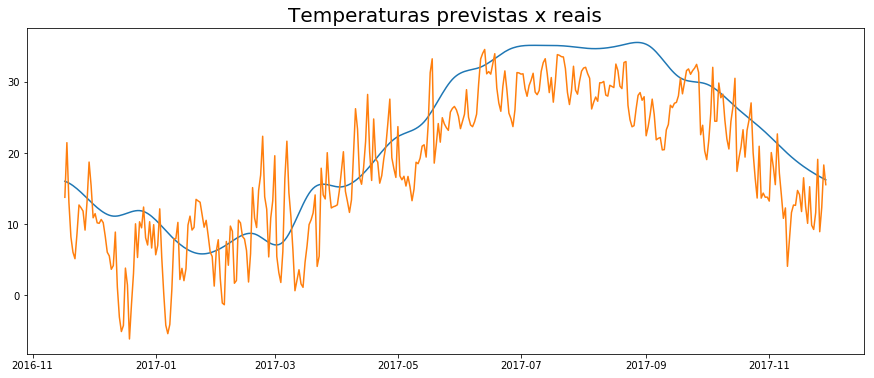

In [290]:
# comparação com os dados reais
plt.plot(pred_data)
plt.plot(real_data)
plt.title('Temperaturas previstas x reais', fontsize=20)
plt.show()

### Medição do escore: RMSE

In [291]:
def rmse(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((predictions - targets) ** 2))

def rmsle(predictions, targets):
    assert len(predictions) == len(targets)
    return np.sqrt(np.mean((np.log(1 + predictions) - np.log(1 + targets)) ** 2))

In [292]:
print('RMSE:', rmse(pred_data['temperature'], real_data['temperature']))

RMSE: 6.194019977115159
